# TinyHiera with multiloader

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from os import path

from torch import nn
from torch.nn import functional as F
from torch.nn.functional import scaled_dot_product_attention
from torch.nn.attention import SDPBackend, sdpa_kernel
from torch.nn.functional import scaled_dot_product_attention
from torch.nn.attention import SDPBackend, sdpa_kernel
from tqdm import tqdm
from einops import rearrange
from torch.optim import AdamW

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from omegaconf import OmegaConf, open_dict
from experanto.datasets import ChunkDataset, SimpleChunkedDataset
from experanto.utils import LongCycler, MultiEpochsDataLoader
from experanto.dataloaders import get_multisession_dataloader


In [2]:
paths = ['dynamic29513-3-5-Video-full',
         'dynamic29514-2-9-Video-full',
         'dynamic29755-2-8-Video-full',
         'dynamic29647-19-8-Video-full',
         'dynamic29156-11-10-Video-full',
         'dynamic29623-4-9-Video-full',
         'dynamic29515-10-12-Video-full',
         'dynamic29234-6-9-Video-full',
         'dynamic29712-5-9-Video-full',
         'dynamic29228-2-10-Video-full'
        ]
full_paths = [path.join("/data/mouse_polly/", f) for f in paths]

NameError: name 'path' is not defined

## Load Config Object from .yaml file

### Modify the config

In [4]:
from experanto.configs import DEFAULT_CONFIG as cfg
cfg.dataset.global_chunk_size = 16
cfg.dataset.global_sampling_rate = 8
cfg.dataset.modality_config.screen.include_blanks=True
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}

cfg.dataloader.num_workers=4
cfg.dataloader.prefetch_factor=1
cfg.dataloader.batch_size=32
cfg.dataloader.pin_memory=True

### Instantiate MultiDataloader

In [5]:
# the multiple dataloader is an iterator that returns a tuple of (key, batch)
train_dl = get_multisession_dataloader(full_paths, cfg)

# Hiera

In [11]:
import torch
from hiera import Hiera
tiny_hiera = Hiera(input_size=(16,144, 256),
                     num_heads=1, 
                     stages=(4, 4, 2), 
                     q_pool=1, 
                     in_chans=1,
                     q_stride=(2, 2, 2),
                     mask_unit_size=(1, 8, 8),
                     patch_kernel=(3, 8, 8),
                     patch_stride=(1, 4, 4),
                     patch_padding=(1, 3, 3),
                     sep_pos_embed=True,)
#tiny_hiera = torch.compile(tiny_hiera).cuda().to(torch.bfloat16);
tiny_hiera = tiny_hiera.cuda().to(torch.bfloat16);

In [12]:
example_in = torch.ones(8,1,16,144, 256).to("cuda", torch.bfloat16)
out = tiny_hiera(example_in, return_intermediates=True);
features = out[1][2]
features.shape

torch.Size([8, 8, 18, 32, 384])

In [10]:
8*18*32

4608

In [8]:
4*18*32

2304

In [9]:
example_in = torch.ones(8,1,16,144, 256).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = tiny_hiera(example_in, return_intermediates=True);

100% 100/100 [00:01<00:00, 78.77it/s]


In [10]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = tiny_hiera(videos, return_intermediates=True);
        if i > 200:
            break

201it [00:13, 14.63it/s]


In [18]:
32*15*16

7680

In [13]:
class IndexedLinearReadout(nn.Module):
    """
    Readout module for MTM models with selectable weights based on 
    input IDs. Based on :class:`torch.nn.Linear`.
    """
    def __init__(
        self,
        unique_ids: int,
        in_features: int = 384,
        out_features: int = 1,
        bias: bool = True,
        device="cuda",
        dtype=torch.float32,
        init_std: float = 0.02,
    ):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.unique_ids = unique_ids
        self.in_features = in_features
        self.out_features = out_features
        self.init_std = init_std

        self.query = nn.Parameter(
            torch.empty(1, 4, unique_ids, 32, **factory_kwargs)
        )
        self.weight = nn.Parameter(
            torch.empty(unique_ids, in_features, out_features, **factory_kwargs)
        )
        if bias:
            self.bias = nn.Parameter(
                torch.empty(1, unique_ids, out_features, **factory_kwargs)
            )
        else:
            self.register_parameter('bias', None)
        self.init_weights()

    def init_weights(self, cutoff_factor: int = 3):
        """See `TorchTitan <https://github.com/pytorch/torchtitan/blob/40a10263c5b3468ffa53b3ac98d80c9267d68155/torchtitan/models/llama/model.py#L403>`__."""
        readout_std = self.in_features**-0.5
        nn.init.trunc_normal_(
            self.weight,
            mean=0.0,
            std=readout_std,
            a=-cutoff_factor * readout_std,
            b=cutoff_factor * readout_std,
        )
        readout_std = self.in_features**-0.5
        nn.init.trunc_normal_(
            self.query,
            mean=0.0,
            std=readout_std,
            a=-cutoff_factor * readout_std,
            b=cutoff_factor * readout_std,
        )
        if self.bias is not None:
            self.bias.data.zero_()

In [14]:
class ELU1(nn.Module):
    """
    Adapted from `NeuralPredictors <https://github.com/sinzlab/neuralpredictors/blob/main/neuralpredictors/layers/activations.py>`__.
    
    Elu activation function shifted by 1 to ensure that the
    output stays positive. That is:
    Elu1(x) = Elu(x) + 1
    """

    def forward(self, x, inplace=False, eps=0.0):
        return F.elu(x, inplace=inplace) + 1.0 + eps

In [15]:
class MouseHiera(nn.Module):
    def __init__(self,
                 backbone,
                 dls,
                 dim=384,
                 dim_head=32,
                 num_heads=4):
        super().__init__()
        self.backbone=backbone
        self.num_heads=num_heads
        self.dim_head=dim_head
        self.wk = nn.Linear(dim, dim_head * num_heads, bias=False)
        self.wv = nn.Linear(dim, dim_head * num_heads, bias=False)
        self.wo = nn.Linear(dim_head * num_heads, dim, bias=False)
        self.readout = nn.ModuleDict()
        self.activation = ELU1()
        for k, v in dls.loaders.items():
            n_neurons = next(iter(v))["responses"].shape[-1]
            self.readout[k] = IndexedLinearReadout(n_neurons, in_features=dim_head*num_heads)
    
    def forward(self, x, key):
        x = self.backbone(x, return_intermediates=True)[1][-1]
        b, t, h, w, d = x.shape
        seq_len = t*h*w
        x = x.view(b, -1, d)
        k, v = self.wk(x), self.wv(x)
        q = self.readout[key].query
        n = q.shape[2]
        q = q.tile(b, 1, 16, 1)
        k = k.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2)
        v = v.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2)
        with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
            o = F.scaled_dot_product_attention(q, k, v)
        o = o.transpose(1,2).contiguous().view(b, -1, self.num_heads * self.dim_head)
        o = self.wo(o)
        o = o.view(b, -1,n, d)
        w = r.readout[key].weight
        o = torch.einsum("btni, njr->bnt", o, w, )
        o = o + r.readout[key].bias
        return self.activation(o)

In [16]:
r = MouseHiera(tiny_hiera, train_dl)
#opt_r = torch.compile(r, )
opt_r = r

In [17]:
torch.set_float32_matmul_precision('medium')
opt_r.backbone.to(torch.bfloat16).cuda();
opt_r = opt_r.train().to(torch.bfloat16).cuda()
opt_r = torch.compile(r).cuda().to(torch.bfloat16)


In [18]:
criteria = nn.PoissonNLLLoss(log_input=False, reduction='mean')
opt = AdamW(opt_r.parameters(), lr=3e-4, fused=True)
import pytorch_warmup as warmup
from torch.amp import autocast
warmup_scheduler = warmup.UntunedLinearWarmup(opt, )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 1e6, eta_min=1e-7)


In [ ]:
losses, corrs, lrs = [], [], []
for train_loop in range(10):
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        #with autocast(device_type='cuda', dtype=torch.bfloat16):
        #    out = opt_r(videos, k);
        #    loss = criteria(out.transpose(1,2), responses)
        out = opt_r(videos, k);
        loss = criteria(out.transpose(1,2), responses)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(opt_r.parameters(), max_norm=1.0, norm_type=2)
        opt.step()

        
        opt.zero_grad()
        losses.append(loss.item())
        with warmup_scheduler.dampening():
            lr_scheduler.step()
        
        if i % 10 ==0:
            r2 = responses.to(torch.float32).cpu().numpy().flatten()
            r1 = out.transpose(1,2).detach().cpu().to(torch.float32).numpy().flatten()
            corrs.append(np.corrcoef(r1,r2)[0,1].item())
            lrs.append(opt.param_groups[0]['lr'])
        if i % 100 ==0:
            print(np.corrcoef(r1,r2)[0,1].item())
    for k, v in train_dl.loaders.items():
        v.dataset.shuffle_valid_screen_times()

1it [00:35, 35.25s/it]

-0.0030187815797289145


8it [02:52, 20.05s/it]W1015 22:40:27.134000 50309 torch/_dynamo/convert_frame.py:844] [0/8] torch._dynamo hit config.cache_size_limit (8)
W1015 22:40:27.134000 50309 torch/_dynamo/convert_frame.py:844] [0/8]    function: 'forward' (/tmp/ipykernel_50309/1076961244.py:21)
W1015 22:40:27.134000 50309 torch/_dynamo/convert_frame.py:844] [0/8]    last reason: 0/0: L['key'] == '29513-3-5'                                     
W1015 22:40:27.134000 50309 torch/_dynamo/convert_frame.py:844] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1015 22:40:27.134000 50309 torch/_dynamo/convert_frame.py:844] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.
101it [04:06,  1.22it/s]

-0.0009066705284804698


201it [05:25,  1.22it/s]

0.0001309505298272993


301it [06:45,  1.23it/s]

-0.00015851095754480253


401it [08:05,  1.22it/s]

-0.0008945773881663632


501it [09:25,  1.22it/s]

0.000657189924042316


601it [10:45,  1.22it/s]

0.0007521493462058877


701it [12:05,  1.22it/s]

-0.0010970021769487147


801it [13:25,  1.22it/s]

0.0015219571705148529


901it [14:45,  1.22it/s]

0.006107271948483915


1001it [16:05,  1.22it/s]

0.020650061250730253


1101it [17:25,  1.22it/s]

0.042269361487252355


1201it [18:45,  1.22it/s]

0.05610961233964572


1301it [20:05,  1.22it/s]

0.07265574429327844


1401it [21:25,  1.22it/s]

0.08987647570812261


1501it [22:46,  1.22it/s]

0.11755845131582252


1601it [24:06,  1.22it/s]

0.11803719192698603


1701it [25:26,  1.22it/s]

0.1277514259496145


1801it [26:46,  1.22it/s]

0.13762374989992537


1901it [28:06,  1.22it/s]

0.12034183286016235


2001it [29:27,  1.21it/s]

0.11963262800024012


2020it [29:42,  1.13it/s]
1it [00:00,  1.15it/s]

0.1314903170565704


101it [01:21,  1.22it/s]

0.12394949133043491


201it [02:41,  1.22it/s]

0.12860030819495633


301it [04:01,  1.22it/s]

0.11990098770508534


401it [05:22,  1.22it/s]

0.12833972601975543


501it [06:42,  1.22it/s]

0.13368350117045932


601it [08:02,  1.22it/s]

0.1256254503567894


701it [09:22,  1.22it/s]

0.12758348291986124


801it [10:43,  1.22it/s]

0.12476677058403475


901it [12:03,  1.21it/s]

0.125857431540451


1001it [13:23,  1.21it/s]

0.12130525179400105


1101it [14:44,  1.21it/s]

0.1227348198923155


1201it [16:04,  1.22it/s]

0.12743266942166506


1301it [17:24,  1.22it/s]

0.12155547383758963


1401it [18:44,  1.22it/s]

0.1321896806211935


1501it [20:05,  1.22it/s]

0.12451761227080475


1601it [21:25,  1.21it/s]

0.13059292220293423


1701it [22:45,  1.21it/s]

0.12170752738530013


1801it [24:06,  1.21it/s]

0.12567918684370663


1901it [25:26,  1.22it/s]

0.1266506534299243


2001it [26:46,  1.22it/s]

0.12673540419001658


2020it [27:01,  1.25it/s]
1it [00:00,  1.13it/s]

0.13091247471622894


101it [01:21,  1.22it/s]

0.12392345482019206


201it [02:41,  1.21it/s]

0.12619300961224647


301it [04:01,  1.21it/s]

0.1292469928353965


401it [05:22,  1.21it/s]

0.1290872628908393


501it [06:42,  1.22it/s]

0.1264510045753323


601it [08:02,  1.21it/s]

0.12257503801000931


701it [09:23,  1.21it/s]

0.13206595836662058


801it [10:43,  1.21it/s]

0.1373620279161928


901it [12:03,  1.21it/s]

0.12377386475766639


1001it [13:24,  1.21it/s]

0.12641307422719325


1101it [14:44,  1.21it/s]

0.133491727236965


1201it [16:04,  1.22it/s]

0.12665278682811845


1301it [17:25,  1.21it/s]

0.12738320677460466


1401it [18:45,  1.21it/s]

0.12242725289065583


1501it [20:06,  1.21it/s]

0.1359532609801698


1601it [21:26,  1.21it/s]

0.12558223140536126


1701it [22:46,  1.22it/s]

0.11968895803185287


1801it [24:06,  1.22it/s]

0.12327008437535819


1901it [25:27,  1.21it/s]

0.1348755327417473


2001it [26:47,  1.21it/s]

0.12788118291971856


2020it [27:02,  1.24it/s]
1it [00:00,  1.13it/s]

0.13021516349030163


101it [01:21,  1.21it/s]

0.13636107682359072


201it [02:41,  1.22it/s]

0.1303473854772985


301it [04:01,  1.21it/s]

0.132500662136166


401it [05:21,  1.22it/s]

0.13608461171218136


501it [06:42,  1.22it/s]

0.1347191643204375


601it [08:02,  1.21it/s]

0.1271433158414445


701it [09:22,  1.22it/s]

0.130551322306112


801it [10:42,  1.21it/s]

0.135590622703362


901it [12:03,  1.21it/s]

0.13294163305846732


1001it [13:23,  1.22it/s]

0.13714194822943424


1101it [14:43,  1.22it/s]

0.14571419831141544


1201it [16:03,  1.21it/s]

0.14287089759953908


1301it [17:23,  1.22it/s]

0.1387154721618933


1401it [18:44,  1.21it/s]

0.12879145233244152


1501it [20:04,  1.21it/s]

0.13805181180247048


1601it [21:24,  1.22it/s]

0.13408424055116294


1701it [22:44,  1.22it/s]

0.14229178412327992


1801it [24:04,  1.22it/s]

0.1396772933998203


1901it [25:25,  1.22it/s]

0.1330898808150413


2001it [26:45,  1.22it/s]

0.13630049405877687


2020it [27:00,  1.25it/s]
1it [00:00,  1.14it/s]

0.13978036693471538


101it [01:20,  1.22it/s]

0.14805664362457094


201it [02:41,  1.22it/s]

0.13742389660634505


301it [04:01,  1.22it/s]

0.15281300754707827


401it [05:21,  1.22it/s]

0.1315235542292562


501it [06:41,  1.22it/s]

0.1363443659475352


601it [08:01,  1.21it/s]

0.14187980617852866


701it [09:21,  1.22it/s]

0.13199413255961212


801it [10:41,  1.22it/s]

0.1504781313582374


901it [12:01,  1.22it/s]

0.14591883162002725


1001it [13:21,  1.22it/s]

0.13747467462340995


1101it [14:42,  1.22it/s]

0.1334751872132065


1201it [16:02,  1.22it/s]

0.1399006775449096


1301it [17:22,  1.21it/s]

0.14647019446446327


1401it [18:42,  1.21it/s]

0.1341222183438074


1501it [20:02,  1.22it/s]

0.14831245127904036


1601it [21:22,  1.22it/s]

0.14329514067141444


1701it [22:42,  1.22it/s]

0.14794622258819934


1801it [24:02,  1.22it/s]

0.14381647657941085


1901it [25:22,  1.22it/s]

0.14195616486354742


2001it [26:42,  1.21it/s]

0.13598274722525497


2020it [26:58,  1.25it/s]
1it [00:00,  1.14it/s]

0.1365524281502156


101it [01:21,  1.20it/s]

0.15314405133411918


201it [02:41,  1.21it/s]

0.13755421281209135


301it [04:02,  1.22it/s]

0.14030258345152385


401it [05:22,  1.21it/s]

0.14020579243307457


501it [06:43,  1.22it/s]

0.1334554908908282


601it [08:03,  1.22it/s]

0.13980072533955695


701it [09:23,  1.21it/s]

0.133729278968914


801it [10:44,  1.21it/s]

0.14264724717713992


901it [12:04,  1.21it/s]

0.1265414913018637


1001it [13:25,  1.21it/s]

0.14315911013030255


1101it [14:46,  1.21it/s]

0.14729623481895976


1201it [16:06,  1.22it/s]

0.13516759864192132


1211it [16:14,  1.22it/s]

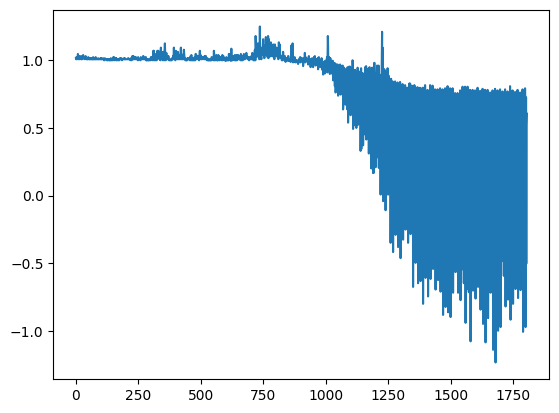

In [16]:
plt.plot(losses)

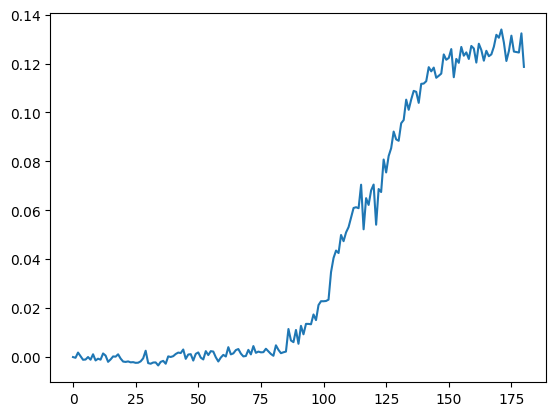

In [17]:
plt.plot(corrs)

In [29]:
losses, corrs = [], []
for _ in tqdm(range(500)):
    
    videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
    responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
    with autocast("cuda", )
        out = opt_r.generate(videos, k);
    loss = criteria(out.transpose(1,2), responses)
    scaler.scale(loss).backward()
    scaler.step(opt)
    scaler.update()
    opt.zero_grad()
    losses.append(loss.item())
    neuron=0
    r2 = responses.to(torch.float32).cpu().numpy().flatten()
    r1 = out.transpose(1,2).detach().cpu().to(torch.float32).numpy().flatten()
    corrs.append(np.corrcoef(r1,r2)[0,1].item())

  0% 0/500 [00:00<?, ?it/s]


RuntimeError: "_amp_foreach_non_finite_check_and_unscale_cuda" not implemented for 'BFloat16'

## Overfitting

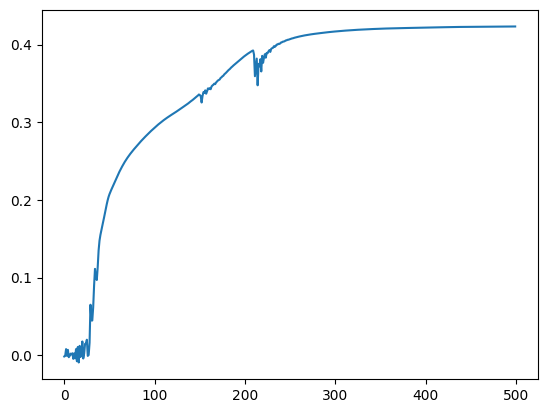

In [16]:
plt.plot(corrs)

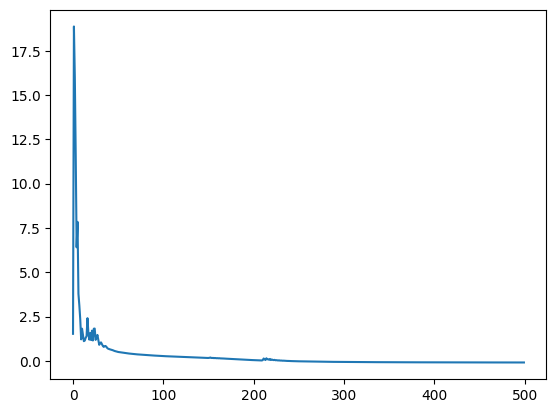

In [17]:
plt.plot(losses)

In [24]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = opt_r(videos, k);
        if i > 200:
            break

7it [00:14,  2.00s/it]/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:168: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
8it [00:22,  4.01s/it]W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8] torch._dynamo hit config.cache_size_limit (8)
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8]    function: 'forward' (/tmp/ipykernel_20839/2467812288.py:21)
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8]    last reason: 0/0: L['key'] == '29513-3-5'                                     
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch

In [25]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = opt_r(videos, k);
        if i > 200:
            break

201it [00:09, 22.31it/s]


In [106]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = opt_r(videos, k);
        if i > 200:
            break

201it [00:08, 22.55it/s]


In [30]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = tiny_hiera(videos,);
        if i > 200:
            break

201it [00:03, 52.64it/s]


In [ ]:
opt.zero_grad()


In [193]:
videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)

In [194]:
from torch.amp import autocast

In [182]:
opt_r.to(torch.bfloat16);

In [183]:
with autocast(device_type='cuda', dtype=torch.float16):
    out = opt_r(videos, k);


In [57]:
out.shape

torch.Size([8, 7495, 16])

In [58]:
loss = criteria(out.transpose(1,2), responses)

In [59]:
loss.backward()

In [61]:
opt.step()

In [63]:
opt.zero_grad()

In [65]:
loss.shape

torch.Size([])

In [186]:
videos.shape

torch.Size([8, 1, 16, 144, 256])

In [196]:
opt_r = opt_r.to(torch.bfloat16)

In [197]:
out = opt_r(videos, k);

In [ ]:
out = opt_r(videos, k);

In [ ]:
losses = []
for _ in tqdm(range(1000)):
    #with autocast(device_type='cuda', dtype=torch.bfloat16):
    videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
    responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
    out = opt_r(videos, k);
    loss = criteria(out.transpose(1,2), responses)
    loss.backward()
    opt.step()
    opt.zero_grad()
    losses.append(loss.item())

 58% 576/1000 [01:24<01:01,  6.84it/s]

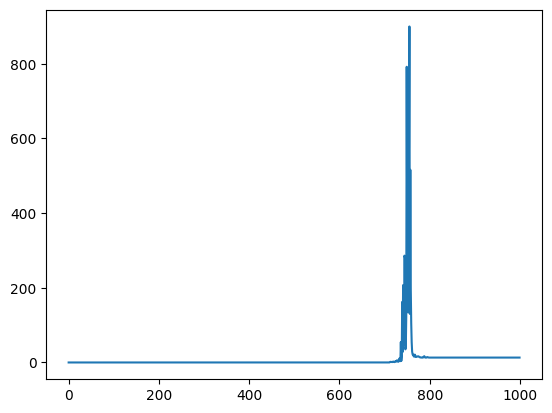

In [218]:
plt.plot(losses)

In [141]:
out.shape

torch.Size([8, 7495, 16])

In [142]:
responses.shape

torch.Size([8, 16, 7495])

In [51]:
neuron=66

0.12096827660364878

In [38]:
out.shape

torch.Size([8, 7495, 16])

In [ ]:
for batch_no, (data_key, data) in tqdm(enumerate(LongCycler(dataloaders["train"])), total=n_iterations,
                                       desc="Epoch {}".format(epoch)):

    loss = full_objective(model, dataloaders["train"], data_key, *data)
    # loss = torch.sum(loss)
    loss.backward()

In [33]:
full_out.shape

torch.Size([8, 7671, 16])

In [ ]:
r.readout["29513-3-5"].bias.shape

In [97]:
full_out = rearrange(full_out, 'b (n t) c -> b t n c', n=7671, t=16)

In [49]:
full_out.shape

torch.Size([8, 16, 7671, 384])

In [50]:
w = r.readout["29513-3-5"].weight

In [51]:
w.shape

torch.Size([7671, 256, 1])

In [54]:
torch.einsum("btni, njr->bnt", full_out, w, )

torch.Size([8, 7671, 16])

In [93]:
full_out.shape

torch.Size([8, 7671, 256])

In [75]:
torch.isnan(full_out).sum()

tensor(960416, device='cuda:0')

In [37]:
with torch.no_grad():
    for i in tqdm(range(100)):
        r(videos, "29513-3-5");

100% 100/100 [00:00<00:00, 110.38it/s]


In [39]:
with torch.no_grad():
    for i in tqdm(range(100)):
        r(videos, "29513-3-5");

100% 100/100 [00:00<00:00, 110.43it/s]


In [43]:
for i in tqdm(range(100)):
    r(videos, "29513-3-5");

100% 100/100 [00:00<00:00, 103.98it/s]


In [29]:
import torch
n_params=0
for n, p in r.readout.named_parameters():
    print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

29513-3-5.query torch.Size([1, 8, 7671, 32]) 1963776
29513-3-5.weight torch.Size([7671, 256, 1]) 1963776
29513-3-5.bias torch.Size([1, 7671, 1]) 7671
29514-2-9.query torch.Size([1, 8, 7495, 32]) 1918720
29514-2-9.weight torch.Size([7495, 256, 1]) 1918720
29514-2-9.bias torch.Size([1, 7495, 1]) 7495
29755-2-8.query torch.Size([1, 8, 8122, 32]) 2079232
29755-2-8.weight torch.Size([8122, 256, 1]) 2079232
29755-2-8.bias torch.Size([1, 8122, 1]) 8122
29647-19-8.query torch.Size([1, 8, 8202, 32]) 2099712
29647-19-8.weight torch.Size([8202, 256, 1]) 2099712
29647-19-8.bias torch.Size([1, 8202, 1]) 8202
29156-11-10.query torch.Size([1, 8, 7440, 32]) 1904640
29156-11-10.weight torch.Size([7440, 256, 1]) 1904640
29156-11-10.bias torch.Size([1, 7440, 1]) 7440
29623-4-9.query torch.Size([1, 8, 7908, 32]) 2024448
29623-4-9.weight torch.Size([7908, 256, 1]) 2024448
29623-4-9.bias torch.Size([1, 7908, 1]) 7908
29515-10-12.query torch.Size([1, 8, 7863, 32]) 2012928
29515-10-12.weight torch.Size([7863,

In [23]:
full_out.shape

torch.Size([8, 7671, 256])

In [38]:
30684/16

1917.75

In [ ]:
30684

In [35]:
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            r(videos, "29513-3-5")

torch.Size([8, 4, 18, 16, 384])
torch.Size([8, 1152, 256])
torch.Size([8, 1152, 256])
torch.Size([32, 8, 7671, 32])
torch.Size([8, 8, 1152, 32])
torch.Size([8, 8, 1152, 32])


In [42]:
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            r(videos, "29513-3-5")

100% 100/100 [00:00<00:00, 110.38it/s]


In [20]:
example_in = torch.ones(32,1,16,144, 144).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(1000)):
        tiny_hiera(example_in);

100% 1000/1000 [00:21<00:00, 46.31it/s]


In [11]:
24*32*16

12288

In [22]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(dl)):
        video_tensor = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        _ = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["eye_tracker"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["treadmill"].to("cuda", torch.bfloat16, non_blocking=True)
        #tiny_hiera(video_tensor);
        if i >300:
            break

301it [00:17, 17.03it/s]


In [24]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(dl)):
        video_tensor = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        _ = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["eye_tracker"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["treadmill"].to("cuda", torch.bfloat16, non_blocking=True)
        tiny_hiera(video_tensor);
        if i >300:
            break

301it [00:22, 13.28it/s]


In [25]:
import torch
n_params=0
for n, p in tiny_hiera.named_parameters():
    #print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

4891336


In [2]:
import hiera

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from hiera import Hiera


In [3]:
hiera

<module 'hiera' from '/usr/local/lib/python3.10/dist-packages/hiera/__init__.py'>

In [1]:
from hiera import Hiera
model = Hiera.from_pretrained("facebook/hiera_base_224.mae_in1k_ft_in1k")  # mae pt then in1k ft'd model
model = Hiera.from_pretrained("facebook/hiera_base_224.mae_in1k") # just mae pt, no ft

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = Hiera.from_pretrained("facebook/hiera_tiny_224.mae_in1k") # just mae pt, no ft

In [3]:

import torch
from hiera import Hiera
my_tiny_hiera = Hiera(embed_dim=96, num_heads=1, stages=(1, 2, 7, 2))

In [4]:
my_cut_hiera = Hiera(input_size=(16,144, 144),
                     num_heads=1, 
                     stages=(1, 2, 2), 
                     q_pool=1, 
                     in_chans=1,
                     q_stride=(1, 2, 2),
                     mask_unit_size=(1, 8, 8),
                     patch_kernel=(3, 7, 7),
                     patch_stride=(2, 4, 4),
                     patch_padding=(1, 3, 3),
                     sep_pos_embed=True,)

In [5]:
my_cut_hiera.eval().cuda().to(torch.bfloat16);

In [6]:
from tqdm import tqdm

In [11]:
example_in = torch.ones(32,1,16,144, 144).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(1000)):
        my_cut_hiera(example_in);

 19% 193/1000 [00:15<01:06, 12.07it/s]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f167ca8b370>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



In [125]:
out = my_cut_hiera(torch.ones(1,1,16,144,144).cuda(), return_intermediates=True)

In [122]:
(out[1])[1].shape

torch.Size([1, 8, 18, 18, 192])

In [81]:
36*4

144

In [69]:
my_cut_hiera.head.projection.weight.shape

torch.Size([1000, 384])

In [75]:
import numpy as np

In [76]:
np.sqrt(384)

np.float64(19.595917942265423)

In [40]:
%debug

> /usr/local/lib/python3.10/dist-packages/hiera/hiera.py(413)forward()
    411             else None,
    412         )
--> 413         x = x + self.get_pos_embed()
    414         x = self.unroll(x)
    415 



ipdb>  x.shape


torch.Size([1, 3888, 96])


ipdb>  self.get_pos_embed().shape


torch.Size([1, 10368, 96])


ipdb>  q


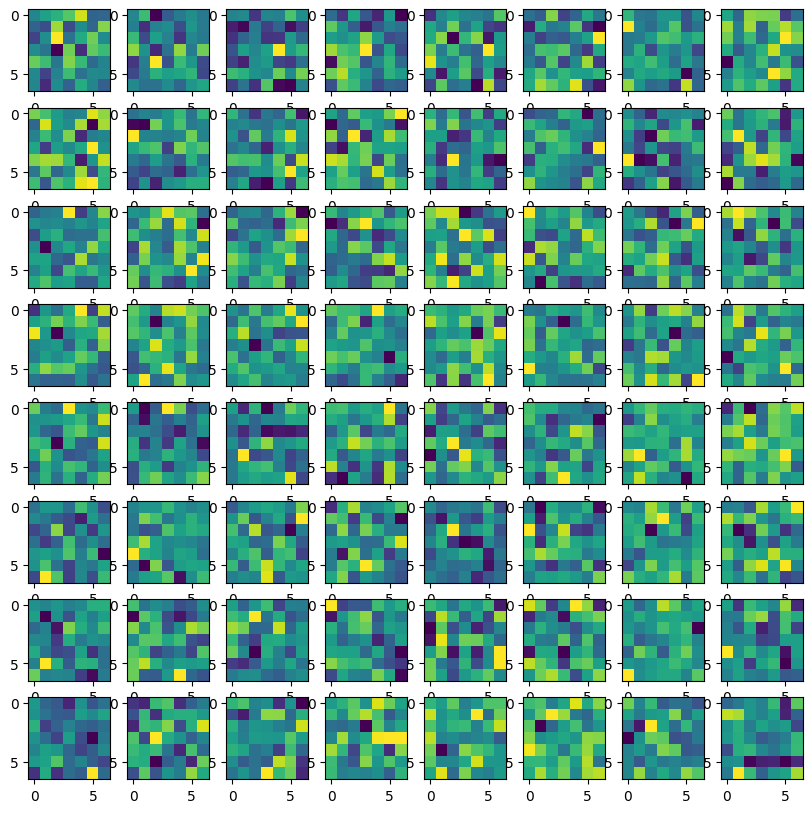

In [83]:
fig, axs = plt.subplots(8,8, figsize=(10,10))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(my_cut_hiera.patch_embed.proj.weight.data[i,0].cpu().numpy())

In [2]:
import torch

In [7]:
some_weights = torch.load("mae_hiera_tiny_224.pth")
my_cut_hiera.load_state_dict(some_weights["model_state"], strict=False)


/tmp/ipykernel_248295/1124240724.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  some_weights = torch.load("mae_hiera_tiny_224.pth")


RuntimeError: Error(s) in loading state_dict for Hiera:
	size mismatch for pos_embed: copying a param with shape torch.Size([1, 3136, 96]) from checkpoint, the shape in current model is torch.Size([1, 2304, 96]).

In [ ]:
fig, axs = plt.subplots(8,12, figsize=(12,8))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(my_cut_hiera.patch_embed.proj.weight.data[i,2].cpu().numpy(), cmap="hot")
    ax.axis("off")

In [8]:
n_params=0
for n, p in my_tiny_hiera.named_parameters():
    #print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

27910216


In [9]:
n_params=0
for n, p in model.named_parameters():
    print#(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

27910216


In [10]:
n_params=0
for n, p in my_cut_hiera.named_parameters():
    #print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

4987336


In [11]:
my_cut_hiera.to("cuda", torch.bfloat16);
my_tiny_hiera.to("cuda", torch.bfloat16);


In [12]:
from tqdm import tqdm

In [13]:
with torch.no_grad():
    for i in tqdm(range(100)):
        my_cut_hiera(torch.ones(500,3,256,144).to("cuda", torch.bfloat16));

100% 100/100 [00:16<00:00,  6.09it/s]


In [15]:
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:22<00:00,  4.48it/s]


In [16]:
my_tiny_hiera = torch.compile(my_tiny_hiera,)

In [9]:
my_tiny_hiera.to("cuda", torch.bfloat16);
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
out = my_tiny_hiera(example, );

In [19]:
# default
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.60it/s]


In [21]:
torch.set_float32_matmul_precision('high')
# default
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.64it/s]


In [22]:
torch.set_float32_matmul_precision('medium')

In [24]:
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)


100% 100/100 [00:13<00:00,  7.63it/s]


In [30]:
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.65it/s]


In [32]:
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.65it/s]


In [36]:
torch.backends.cuda.enable_flash_sdp(False)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:22<00:00,  4.46it/s]


In [37]:
torch.backends.cuda.enable_flash_sdp(True)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:22<00:00,  4.37it/s]


In [4]:
import torch

In [15]:
example.shape


torch.Size([500, 3, 224, 224])

In [5]:
torch.__version__

'2.6.0.dev20240913+cu121'

In [14]:
%debug

> /usr/local/lib/python3.10/dist-packages/hiera/hiera.py(100)forward()
     98         if hasattr(F, "scaled_dot_product_attention"):
     99             # Note: the original paper did *not* use SDPA, it's a free boost!
--> 100             x = F.scaled_dot_product_attention(q, k, v)
    101         else:
    102             attn = (q * self.scale) @ k.transpose(-1, -2)



ipdb>  F


<module 'torch.nn.functional' from '/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py'>


ipdb>  k.shape


torch.Size([500, 1, 49, 64, 96])


ipdb>  q


In [21]:
from tqdm import tqdm
torch.set_float32_matmul_precision('medium')
from torch.nn.attention import SDPBackend, sdpa_kernel
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            out = my_tiny_hiera(torch.ones(10,3,224,224).to("cuda", torch.bfloat16), );

  0% 0/100 [00:00<?, ?it/s]


RuntimeError: No available kernel. Aborting execution.

In [2]:
128*8*3*224*224*2 / 1e9

0.308281344

In [ ]:
! 

In [ ]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))